# StackOverflow Survey Analysis
#### Individual responses on the 2017 Developer Survey fielded by Stack Overflow

### Project Outline
Following the CRISP-DM process, the project is broken into the following parts:
1. Business Understanding/Questions
2. Data Understanding
3. Data Preparation/Analysis
4. Modeling and Evaluation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

# Function for large plots
def setup_large_plot():
    plt.figure(figsize=(12,8), dpi=200)
    plt.tick_params(labelsize='large')

/Users/jingzhaogao/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Business Understanding/ Questions
- What are the most valued skills in the tech industry?
- What actions should you take to break into the field?
- Does higher education lead to higher salaries and job satisfaction?
- Can we predict the salary?

# Data Understanding
- Created a function to understand what each column means
- Printed column descriptions to a text file for easier read
- Conducted descriptive statistics to understand the data

In [2]:
# Import the two datasets
df = pd.read_csv('data/survey_results_public.csv')
schema = pd.read_csv('data/survey_results_schema.csv')
print('df has a shape of ' + str(df.shape))
print('schema has a shape of ' + str(schema.shape))
df.head(3)

df has a shape of (19102, 154)
schema has a shape of (154, 2)


,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN


According to the graph below, we are dealing with a large number of missing values

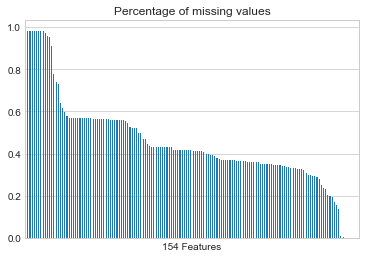

In [3]:
# Missing Values
df.isnull().mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Percentage of missing values');
plt.xticks([],[]);
plt.xlabel('154 Features');

In [4]:
# Create a function to get the column description
def get_description(column_name, schema=schema):
    
    '''
    Input - column name from df, schema dataframe
    Output - The original question asked by stackoverflow
    '''
    
    desc = list(schema[schema['Column'] == column_name]['Question'])[0]
    return desc

In [5]:
# Example
get_description('FormalEducation')

"Which of the following best describes the highest level of formal education that you've completed?"

In [6]:
# Print out all the columns descriptions into a text file for easier read
# for col in df.columns:
    
#     print(col)
#     print(get_description(col))
#     print(df[col].unique()[:5])
#     print('\n')

### Explore some descriptive statistics from the data
As we can see, most of the distributions are skewed. Most people have high satisfactions regarding career, job and stackoverflow; most people earn salary around the 50K range; the data of "HoursPerWeek" seems a bit off, removing this column in later steps.

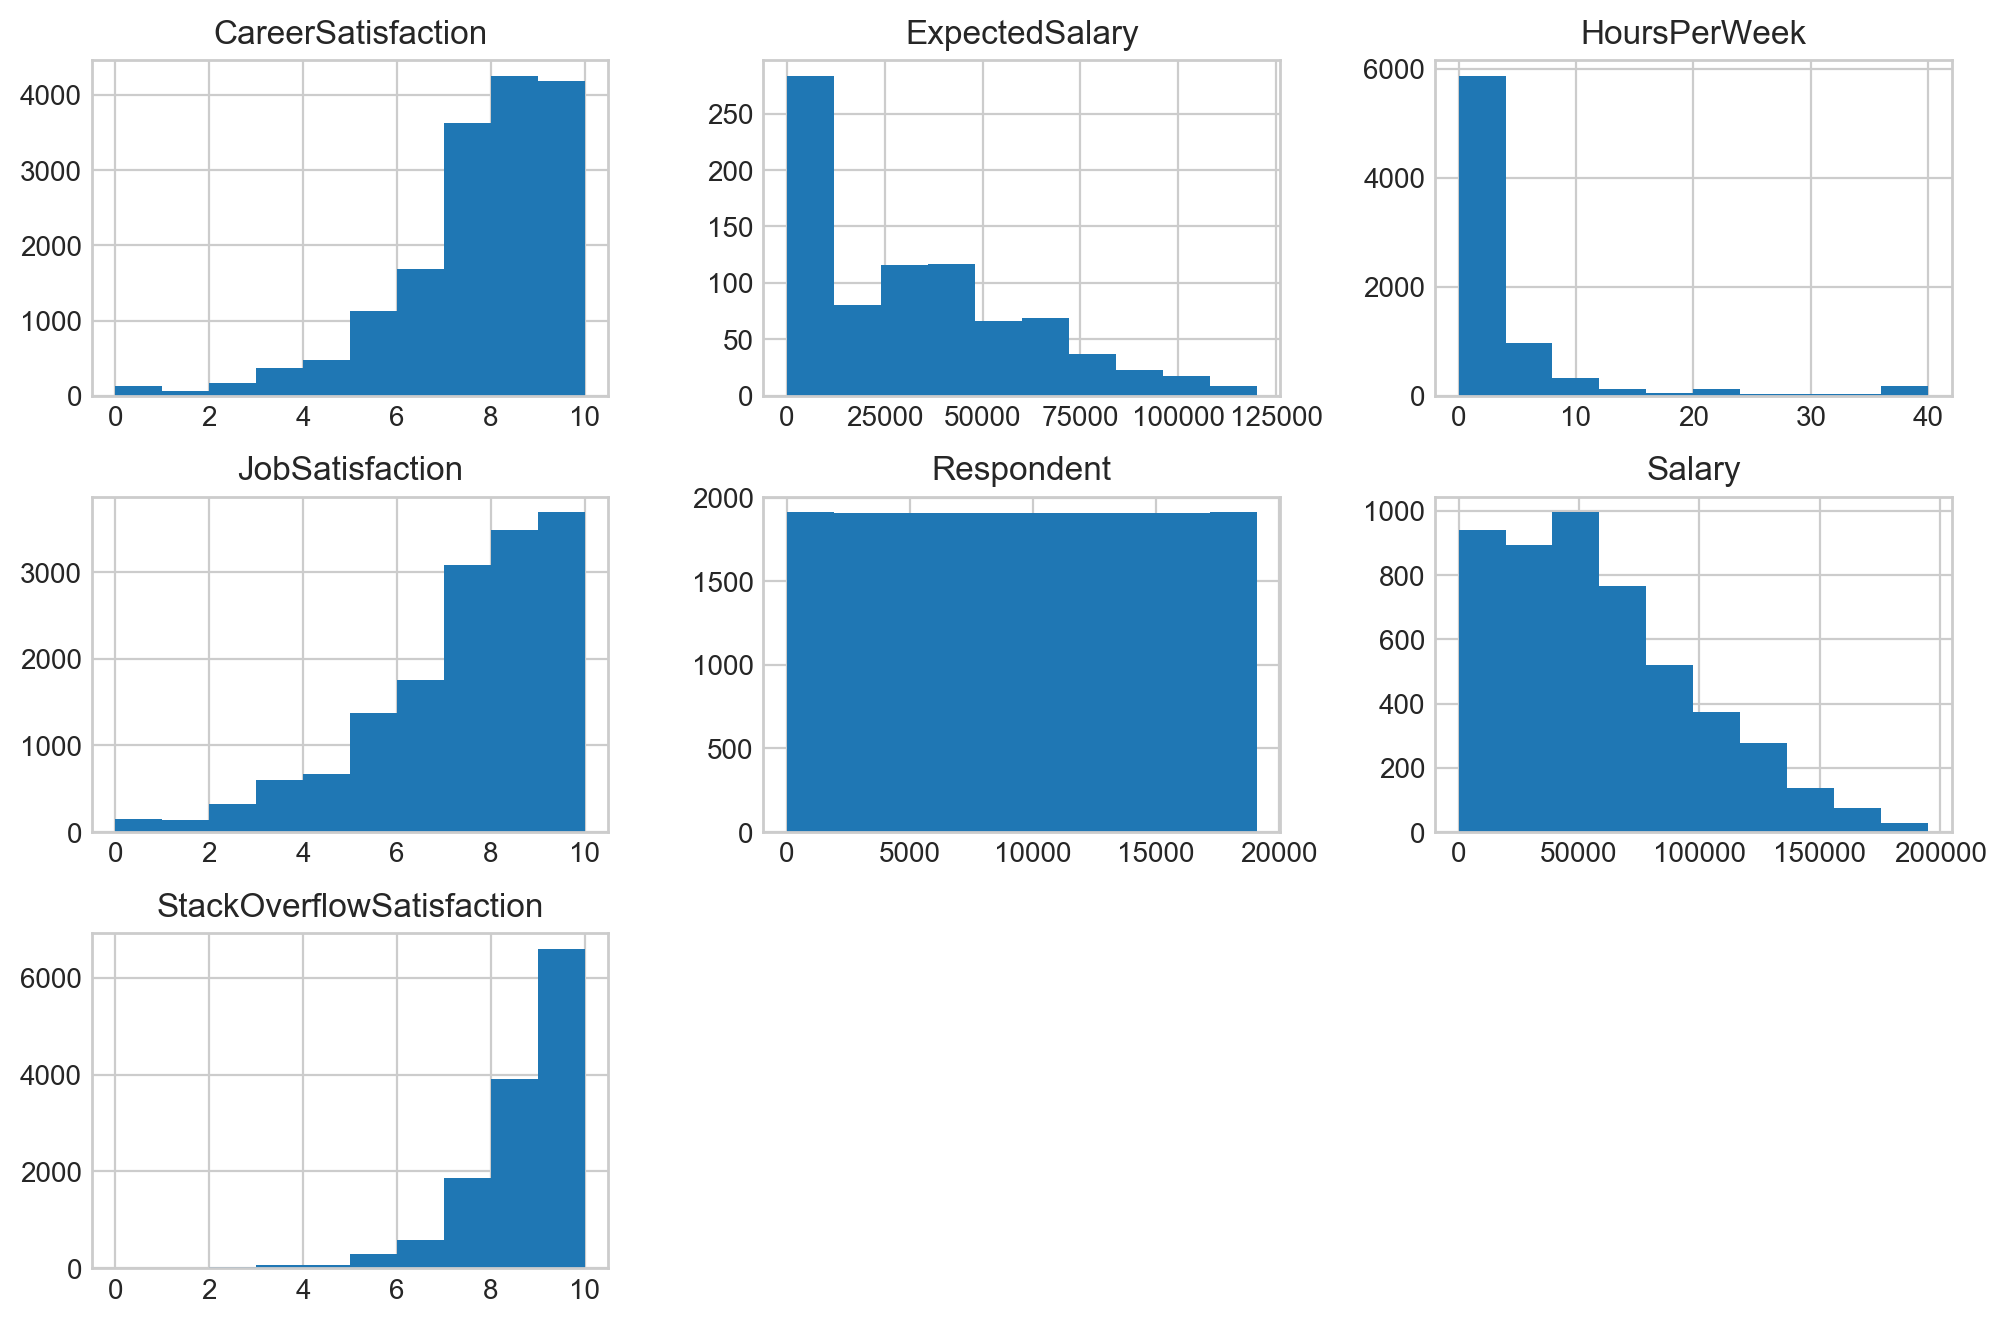

In [7]:
# Examine the histograms of continuous variables
fig = setup_large_plot()
df.hist(ax = plt.gca());

### Created a function to quickly plot some categorical variables
According to the plots, most users are professional developers, and most people own a bachelor's degree.

In [8]:
# Function to plot count of categorical features
def category_countplot(df, col):
    
    '''
    Input - dataframe, column from the dataframe
    Output - count plot of the values in the column
    '''
    
    fig = setup_large_plot()
    (df[col].value_counts()/len(df)).sort_values().plot(kind='barh', ax = plt.gca());
    plt.title('Percentage of ' + col, size=16)

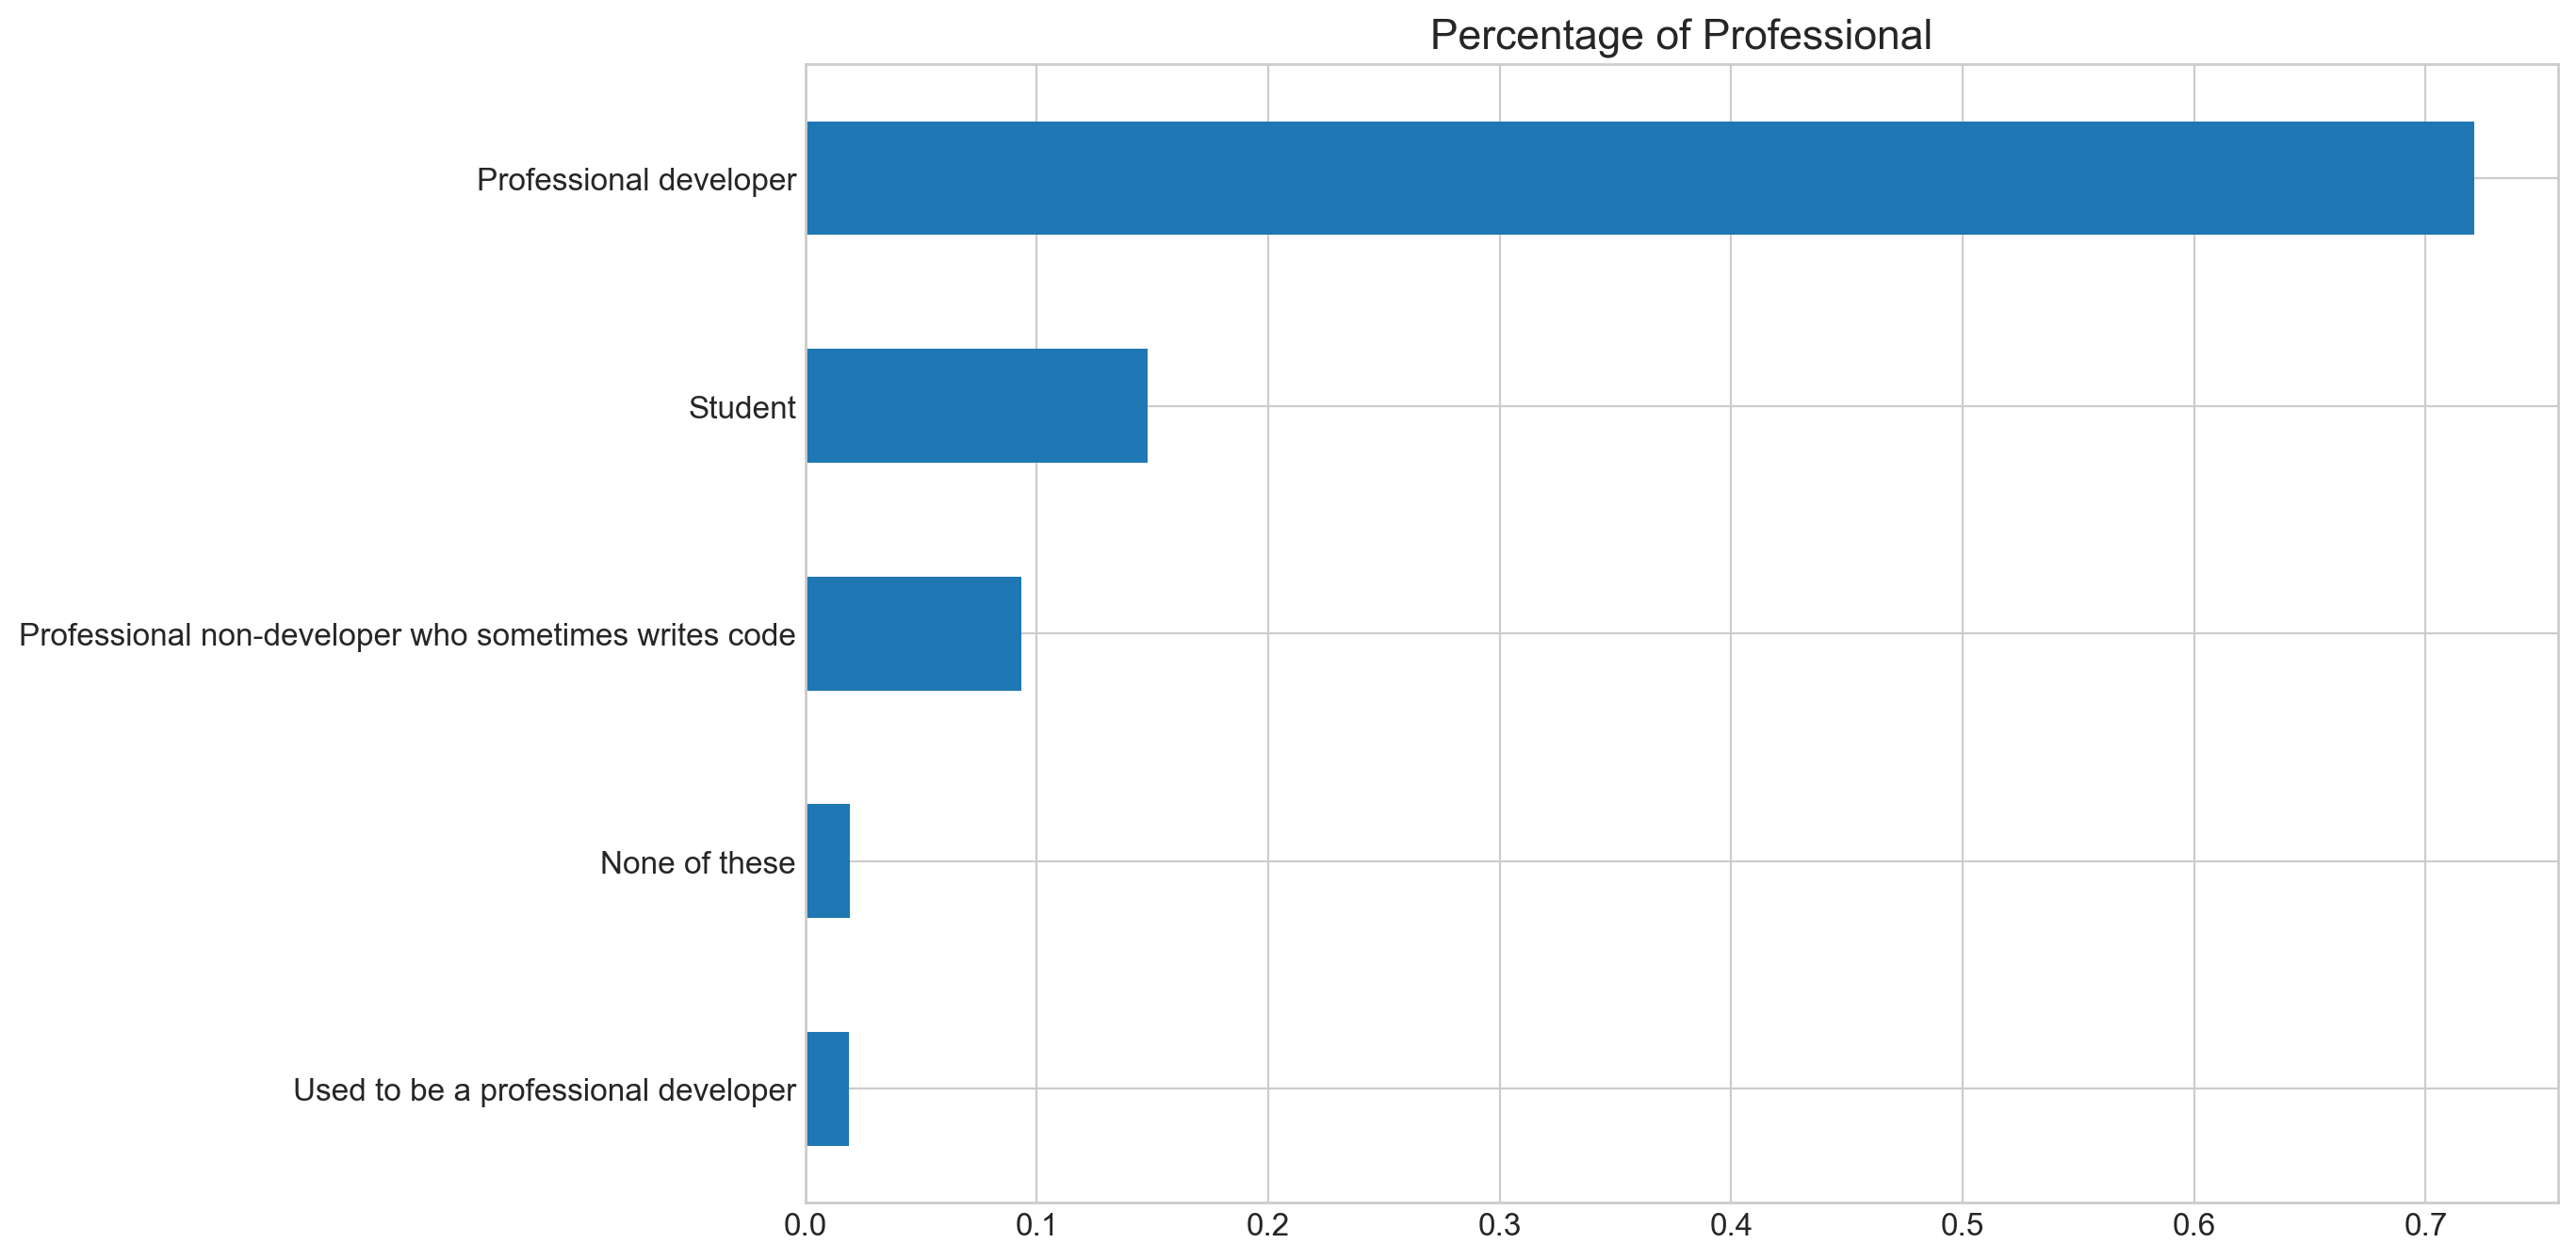

In [9]:
category_countplot(df, 'Professional')

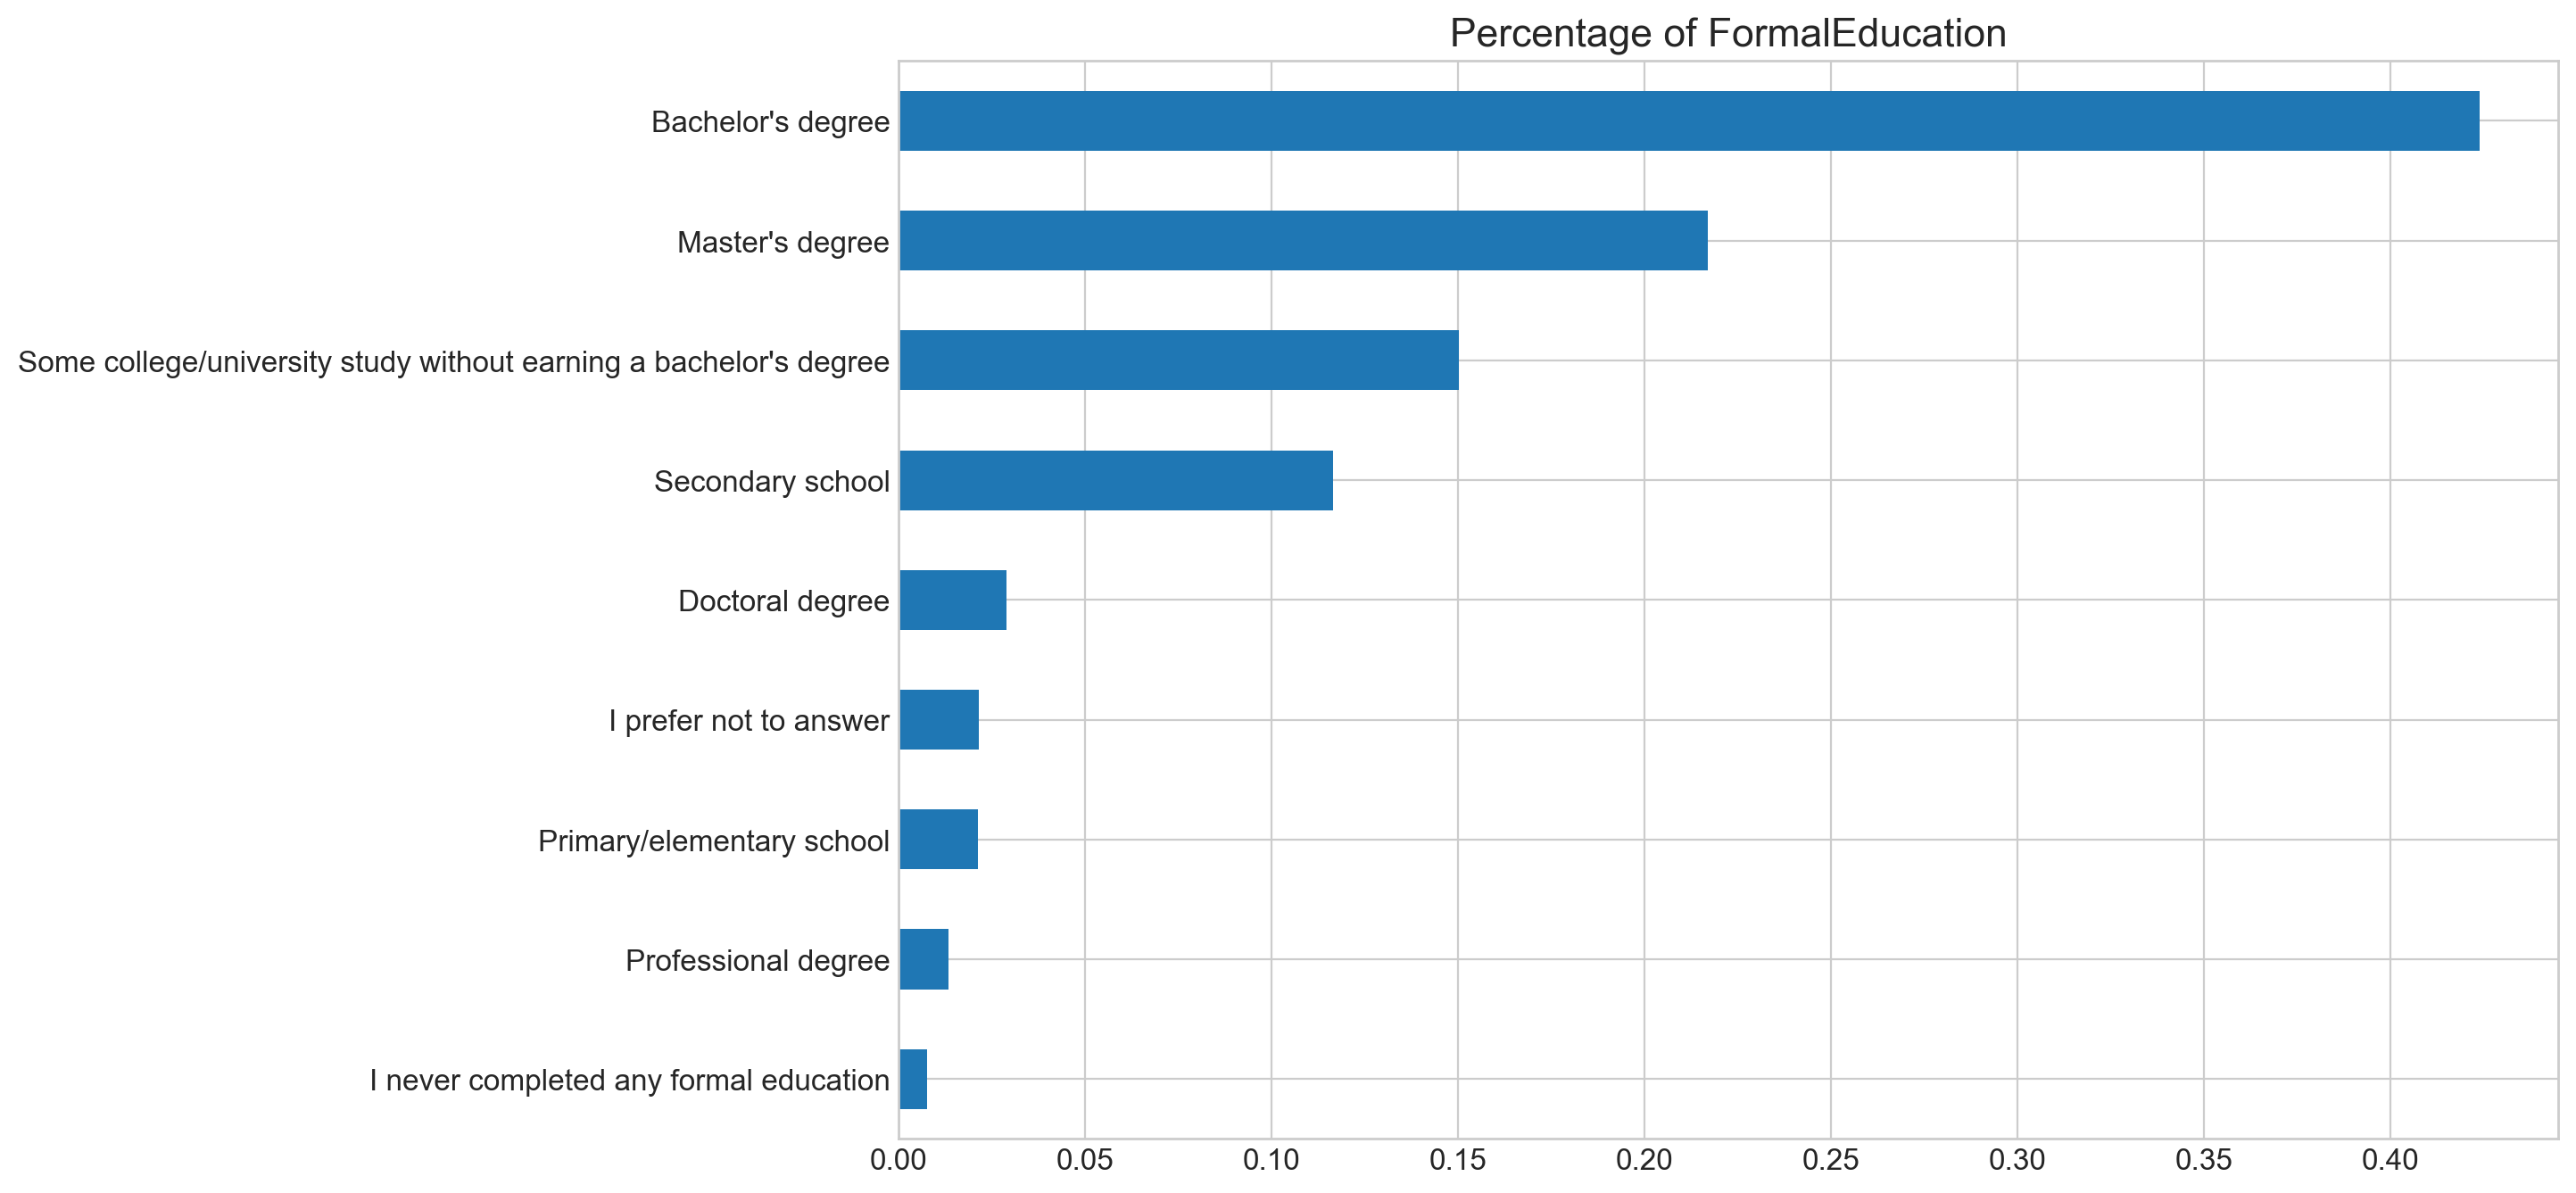

In [10]:
category_countplot(df, 'FormalEducation')

# Data Preparation/Analysis
- Some data transformation was required to analysis the most important skills
- Wrote an algorithm to clean the data that are seperated by semicolons in order to count each instance seperately
- Examined the distributions of salary and job satisfaction by whether the user has an advanced degree


### What are the most valued skills in the tech industry?
What skills would developers prioritize if they were in charge of hiring developers?

In [11]:
# Get the description of this column
get_description('ImportantHiringAlgorithms')

"Congratulations! You've just been put in charge of technical recruiting at Globex, a multinational high- tech firm. This job comes with a corner office, and you have an experienced staff of recruiters at your disposal. They want to know what they should prioritize when recruiting software developers. How important should each of the following be in Globex's hiring process? Knowledge of algorithms and data structures"

In [12]:
# Extract the column names related to these types of questions
important_skills = [col for col in df.columns if col.startswith('ImportantHiring')]
print(important_skills)

['ImportantHiringAlgorithms', 'ImportantHiringTechExp', 'ImportantHiringCommunication', 'ImportantHiringOpenSource', 'ImportantHiringPMExp', 'ImportantHiringCompanies', 'ImportantHiringTitles', 'ImportantHiringEducation', 'ImportantHiringRep', 'ImportantHiringGettingThingsDone']


In [13]:
# Create a dataset to capture the value counts of each question
importance_df = pd.DataFrame()

for skill in important_skills:
    
    # Initial the first dataset of the first skill
    temp_df = pd.DataFrame(df[skill].value_counts())
    
    # Iterate through the important skills to merge into a dataset
    if len(importance_df) == 0:
        importance_df = temp_df
    else:
        importance_df = pd.merge(importance_df, temp_df, left_index=True, right_index=True)

# Tranform the dataset to a more readable format
importance_df.T

,Important,Somewhat important,Very important,Not very important,Not at all important
ImportantHiringAlgorithms,4463,3215,2218,857,137
ImportantHiringTechExp,4030,3718,1563,1381,202
ImportantHiringCommunication,4991,1848,3701,283,56
ImportantHiringOpenSource,1989,4075,498,3352,950
ImportantHiringPMExp,2281,3864,549,3188,987
ImportantHiringCompanies,2057,4487,306,3249,752
ImportantHiringTitles,1883,4075,297,3388,1216
ImportantHiringEducation,2005,4204,341,3252,1081
ImportantHiringRep,857,2801,204,4211,2805
ImportantHiringGettingThingsDone,4878,1779,3760,361,71


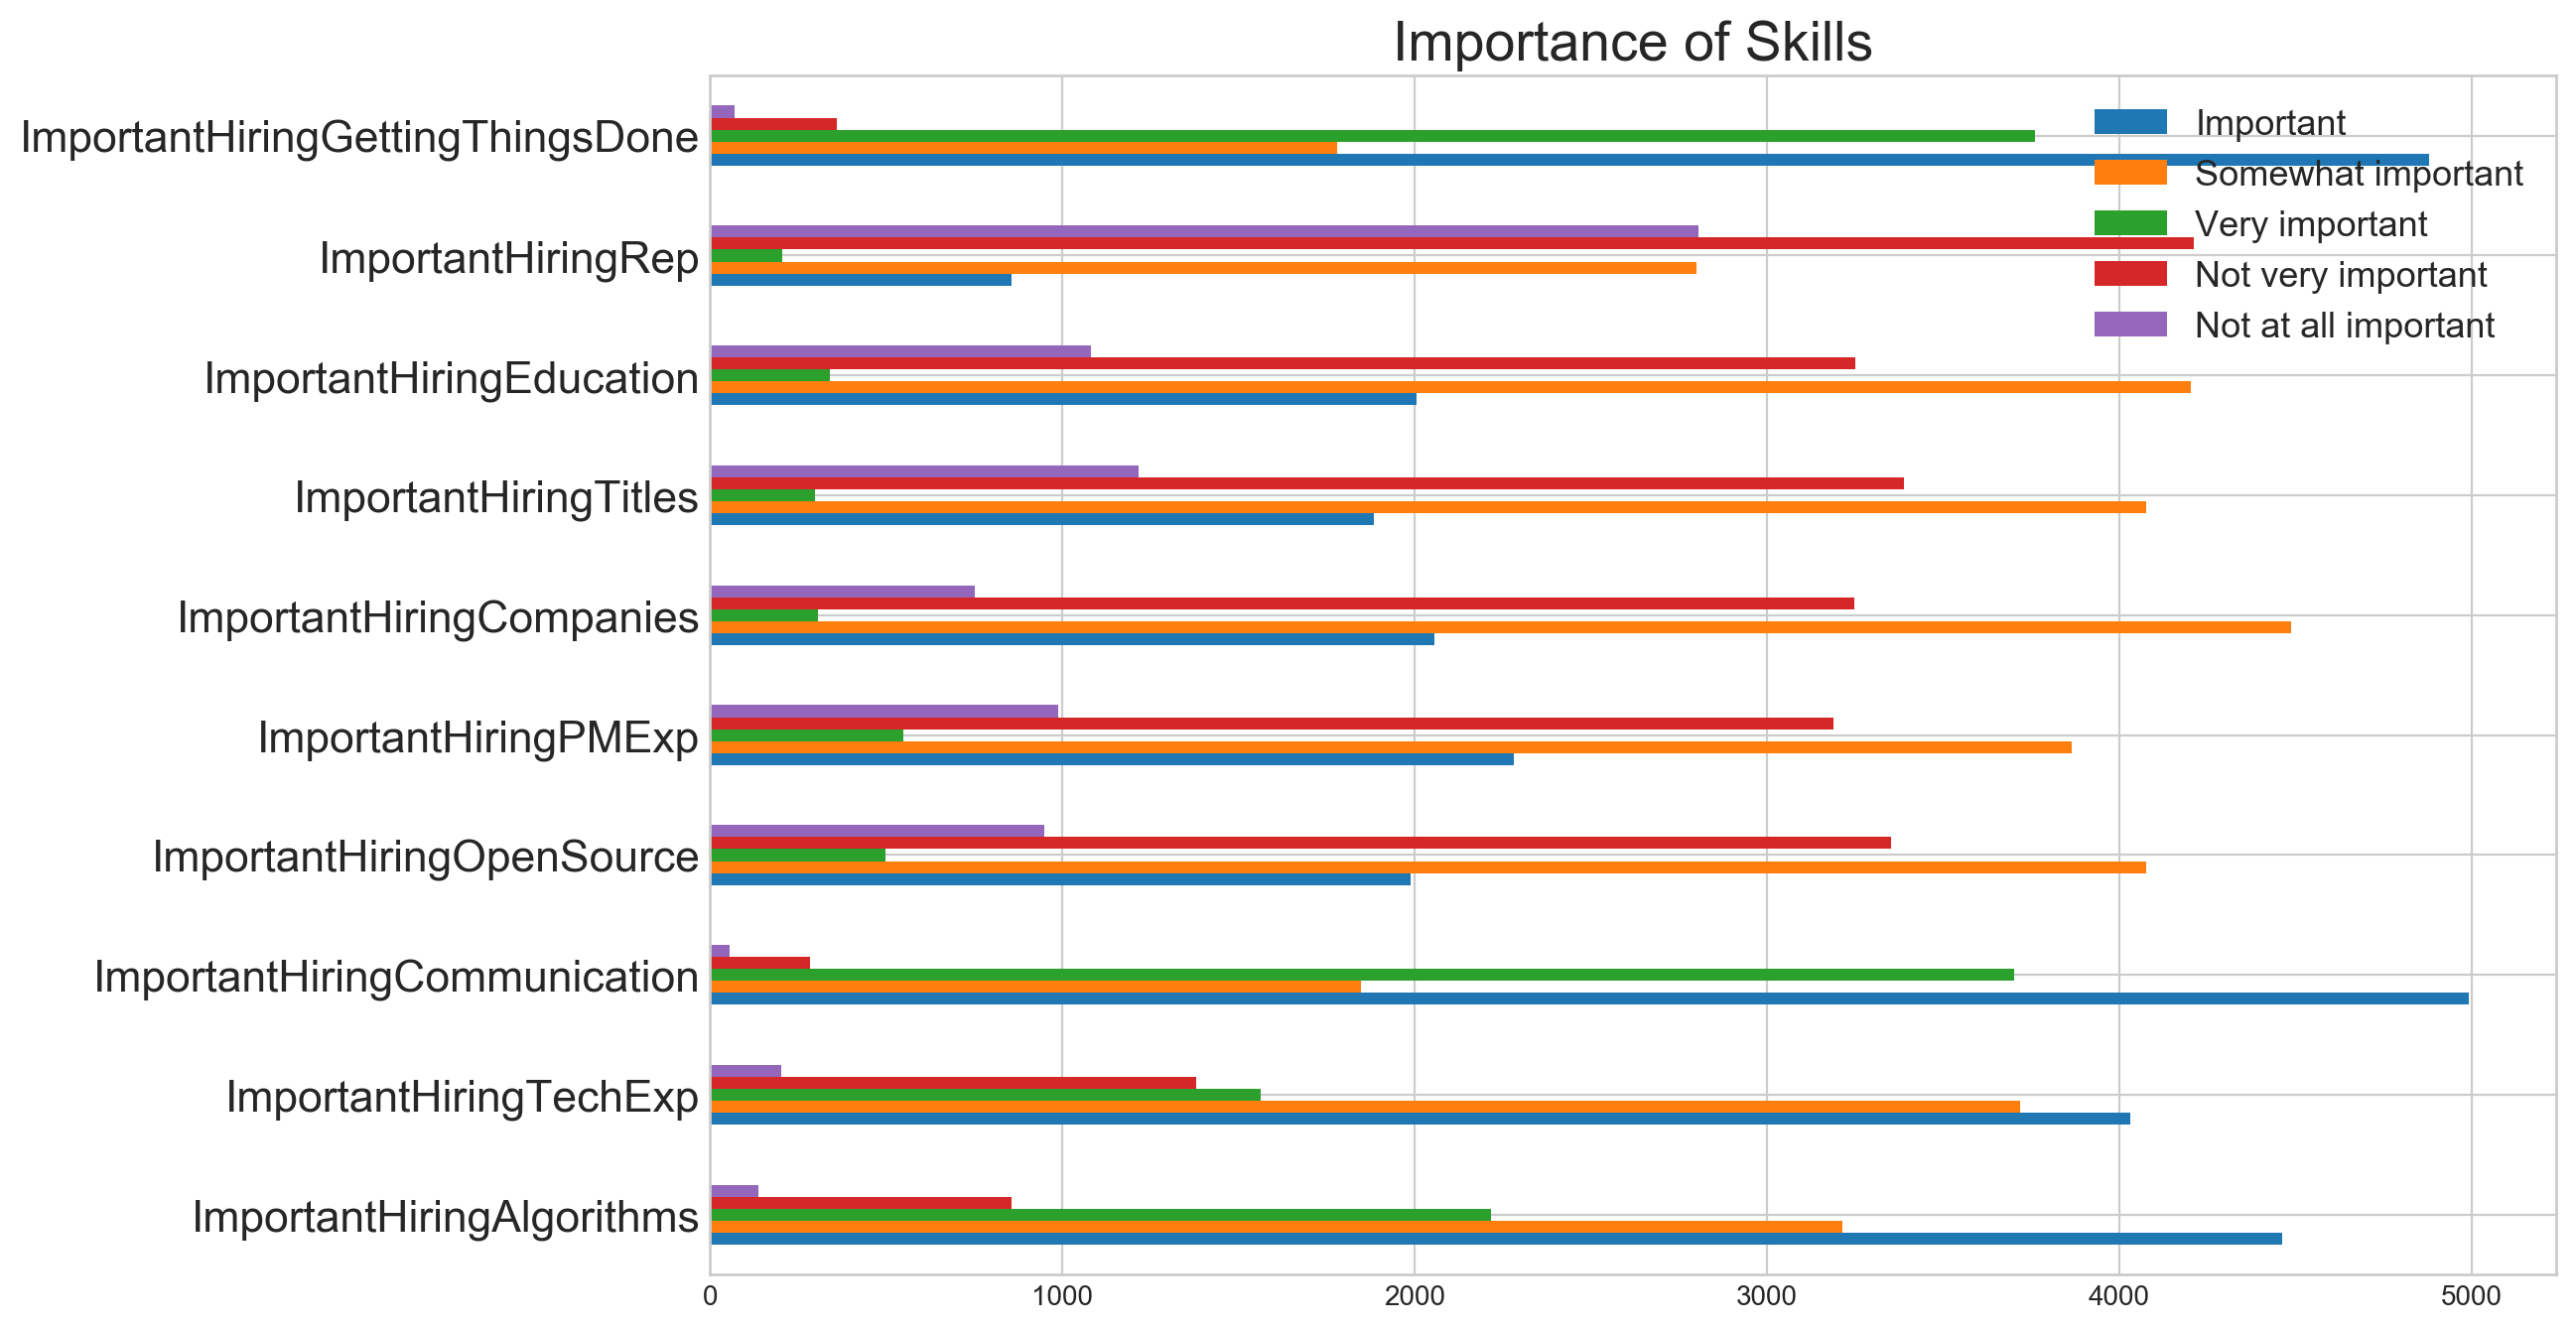

In [14]:
# Plot the results
fig = plt.figure(figsize=(12,8), dpi=200)
importance_df.T.plot(kind='barh', ax = plt.gca());
plt.title('Importance of Skills', size=20);
plt.yticks(size=16);
plt.legend(prop={'size': 13}, loc=1);

### How to break into the field from a non-cs background?
What advice would developers give to their hypothetical cousins regarding how to break into the tech industry from non-cs backgrounds?

In [15]:
# This was the question asked by stackoverflow
get_description('CousinEducation')

"Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?\nLet's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?\nLet's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which 

In [16]:
# The data is not broken down into pieces, some data cleaning is required
cousin_advices = [i for i in df['CousinEducation'].dropna()]
cousin_advices[:5]

['Get a job as a QA tester',
 'Get a job as a QA tester; Conferences/meet-ups',
 'Take online courses; Contribute to open source; Buy books and work through the exercises; Conferences/meet-ups',
 'Contribute to open source; Buy books and work through the exercises; Other',
 'Take online courses; Contribute to open source; Part-time/evening courses']

In [17]:
# The advices from one user are seperated using ;
# Break them up into individual advices to better count each advice
individual_cousin_advices = []

for advice in cousin_advices:
    
    if ';' in advice:
        temp_list = advice.split('; ')
        individual_cousin_advices += temp_list
    
    else:
        individual_cousin_advices.append(advice)

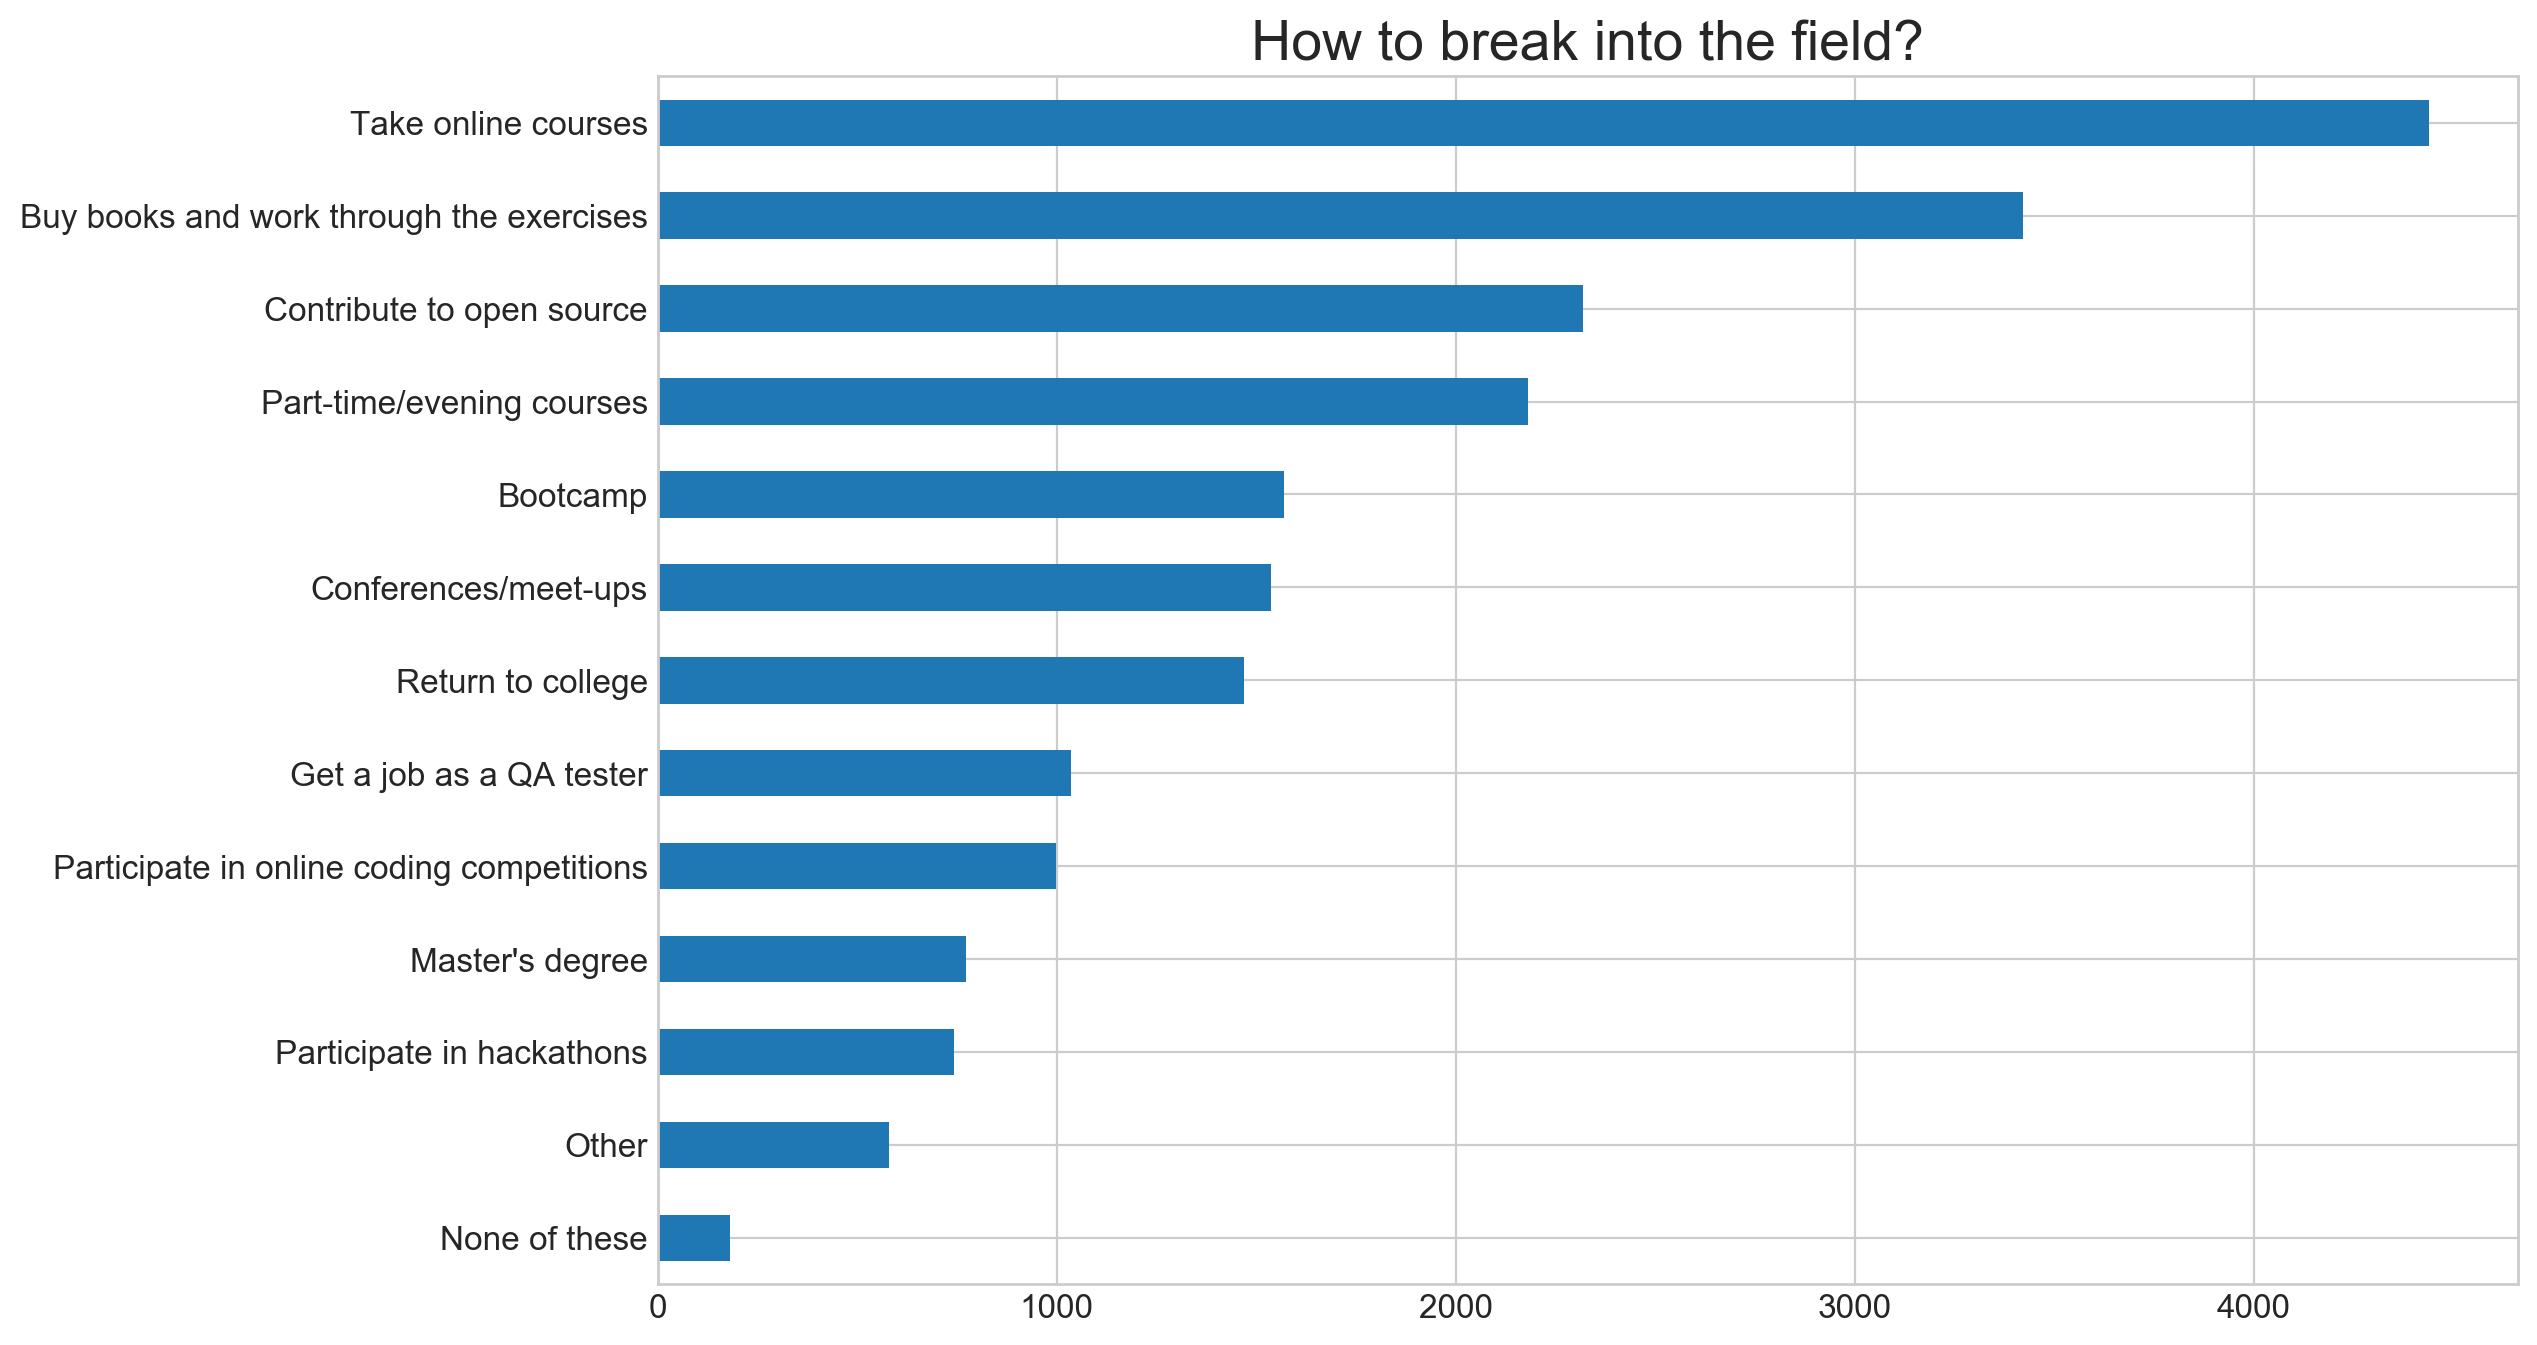

In [18]:
# Evidently, most people recommend taking online courses
setup_large_plot()
pd.Series(individual_cousin_advices).value_counts().sort_values().plot(kind='barh');
plt.title('How to break into the field?', size=20);

### Does higher education lead to higher salaries and job satisfaction?
Examine the distributions of salary and job satisfaction to find the gap between users who have an advanced degree and users who don't.

In [19]:
# Find out the percentage of people from higher education
df['HigherEd'] = df["FormalEducation"].apply(lambda x: x in ("Master's degree", "Doctoral", "Professional degree"))
print(str(round(df['HigherEd'].mean()*100,2)) + '% of users have a degree in higher education')

23.02% of users have a degree in higher education


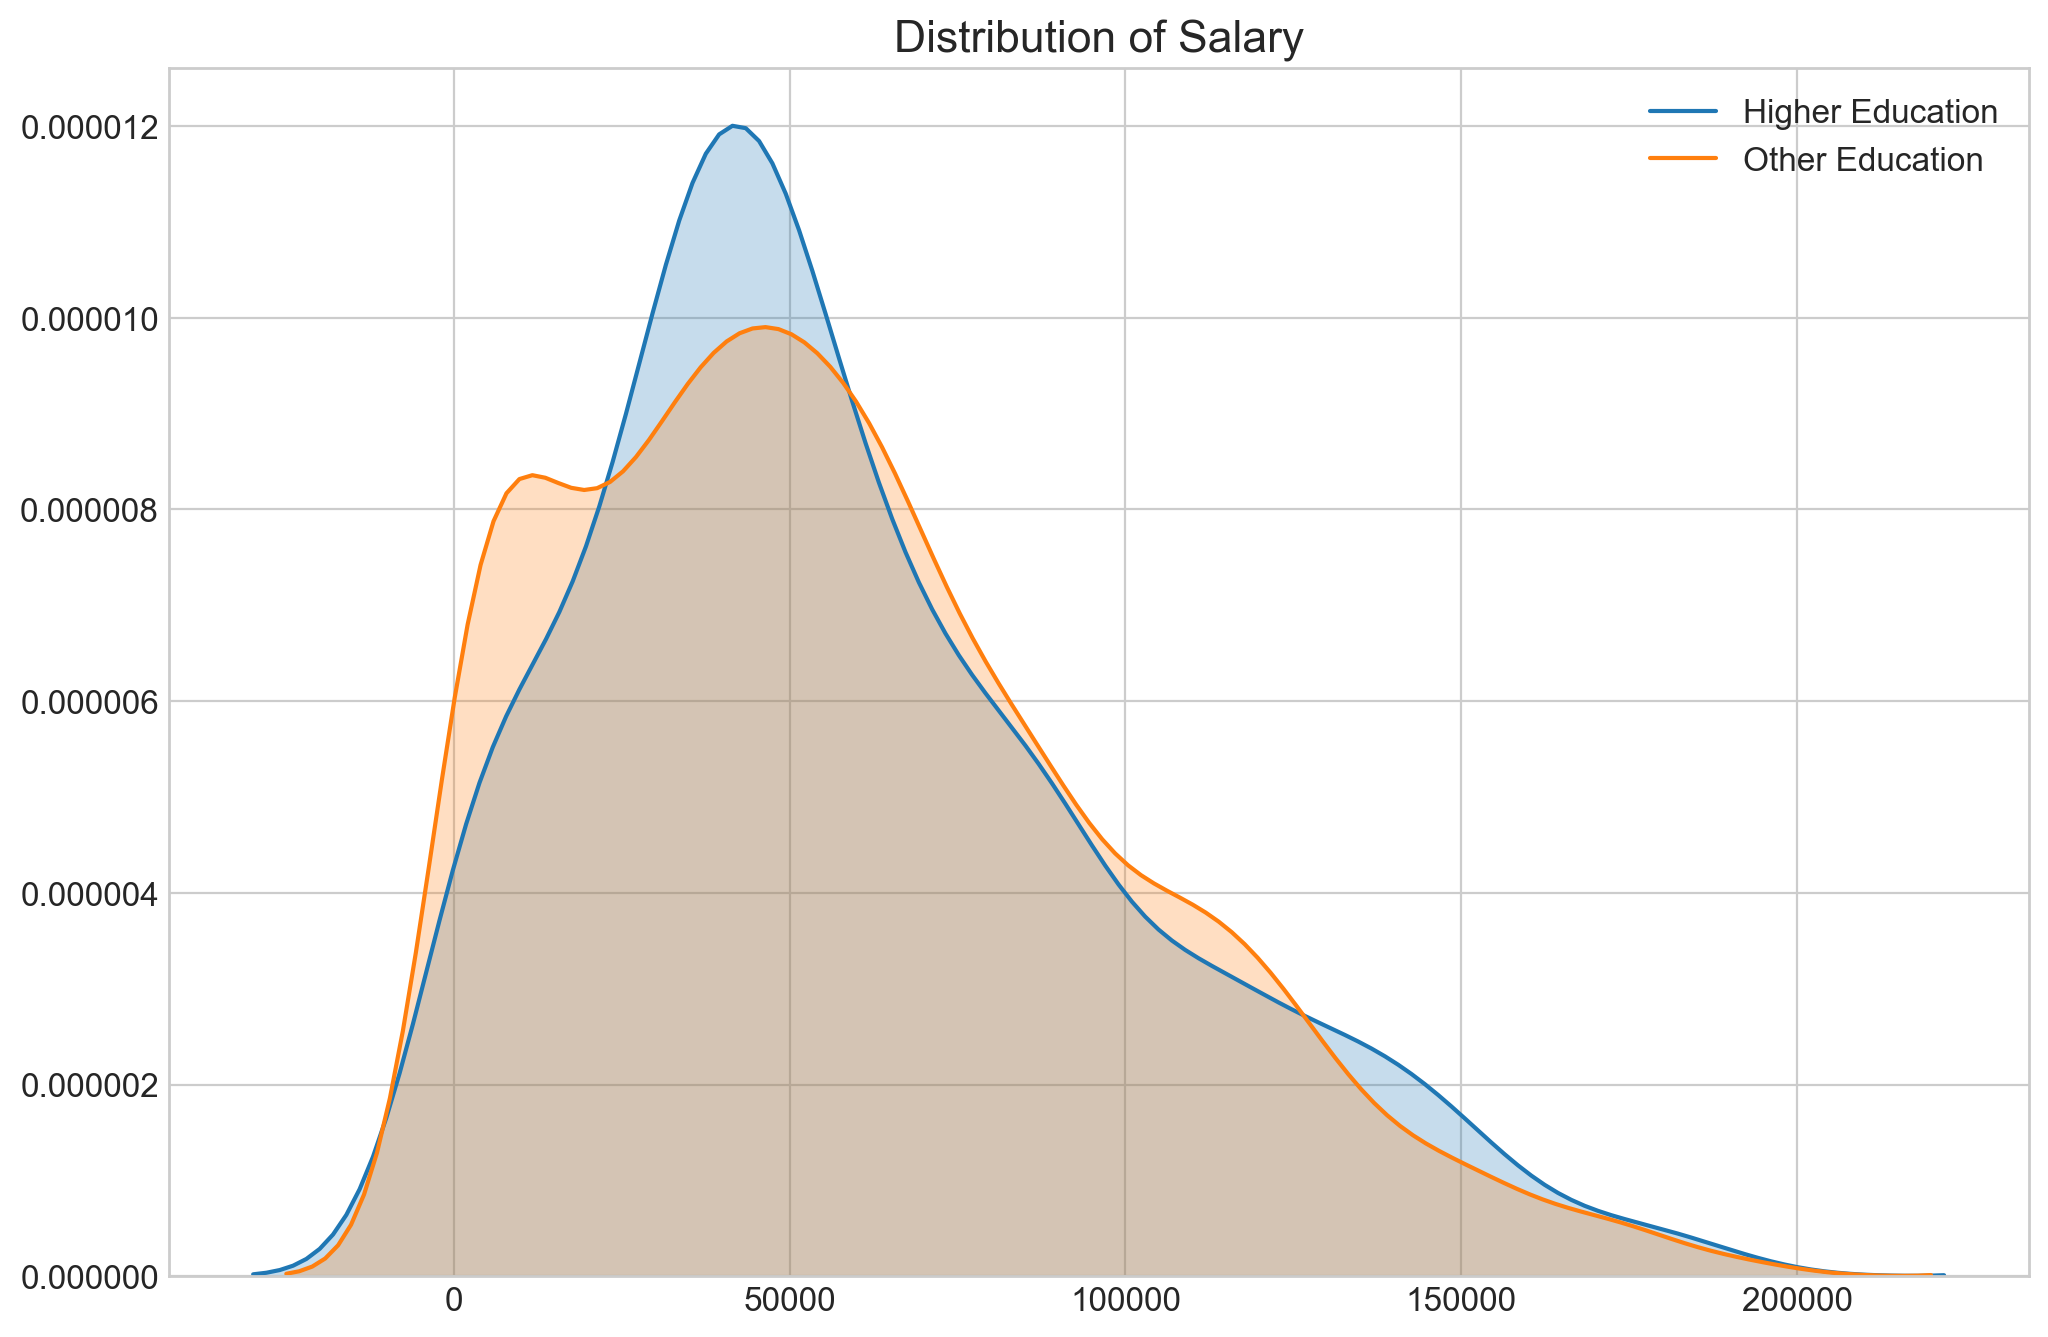

In [20]:
# Plot the distribution of salary of the two groups
setup_large_plot()
sns.kdeplot(df[df['HigherEd'] == True]['Salary'].dropna(), shade=True, label='Higher Education');
sns.kdeplot(df[df['HigherEd'] == False]['Salary'].dropna(), shade=True, label='Other Education');
plt.title('Distribution of Salary', size=16);
plt.legend(prop={'size': 12});

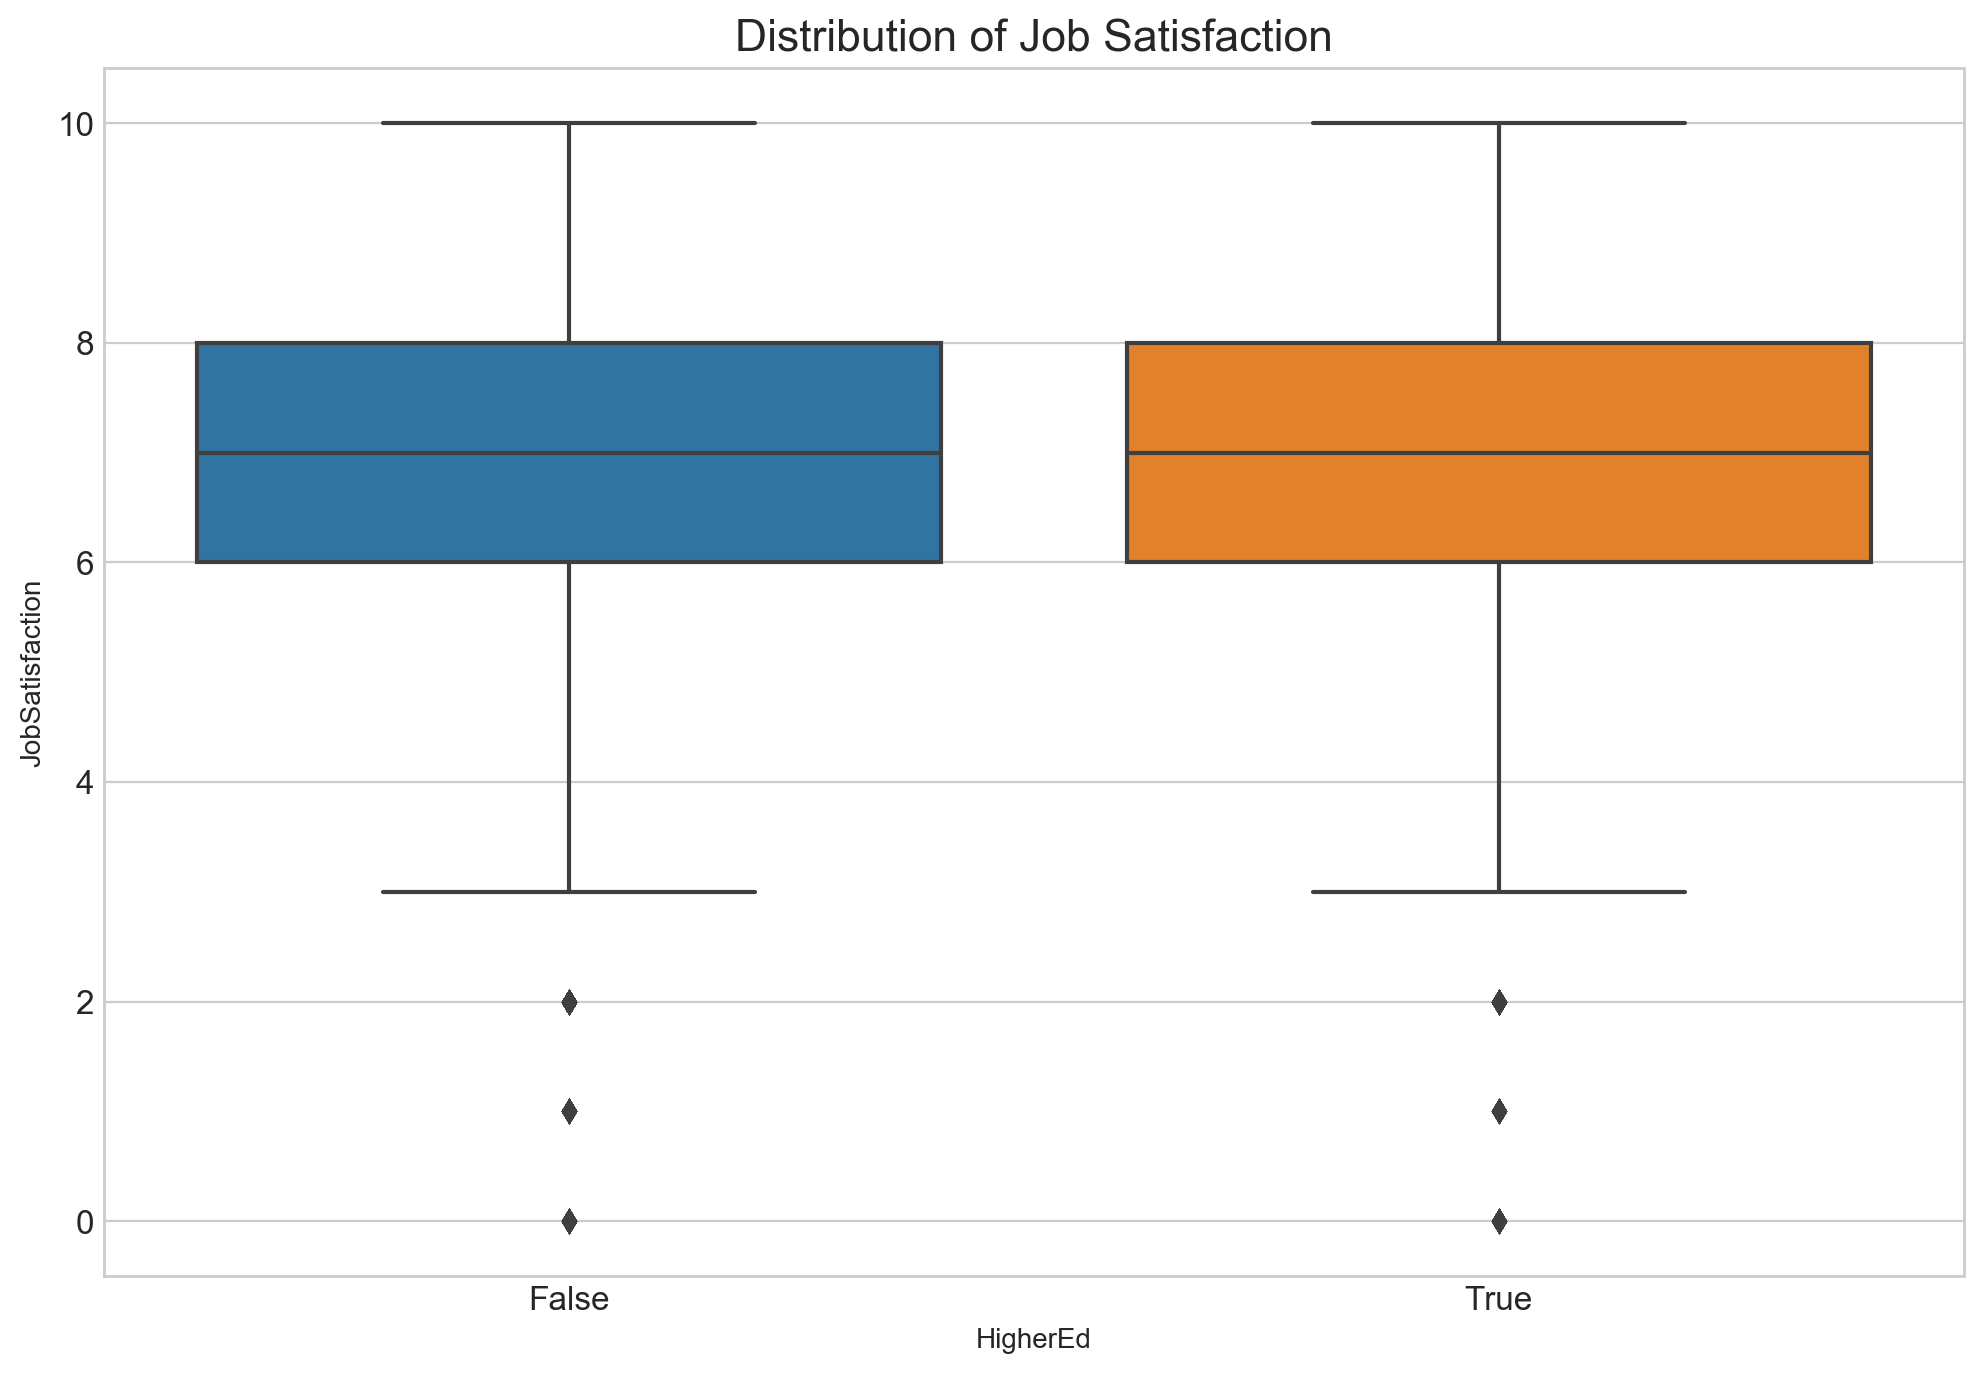

In [21]:
# Plot the distributions of job satisfaction of the two groups
setup_large_plot()
sns.boxplot(data=df, x='HigherEd',y='JobSatisfaction');
plt.title('Distribution of Job Satisfaction', size=16);

# Modelling and Evaluation

### Can we predict the salary?
Prepare the data for a Linear Regression model
- Impute numerical variables with the appropriate method
- Transform categorical variables into dummy variables
- Reduced the number of features by creating a function that filters variables with a certain ratio of 1s in it, and found out that 803 variables is the optimal number of variables before overfitting the training set

In [22]:
# Filter the data where salary is NOT NULL
salary_df = df[df['Salary'].isnull() == False]

# Create a categorical df and numerical df to process them seperately
cat_df = salary_df.select_dtypes('object')
num_df = salary_df.select_dtypes(include=['int', 'float'])
num_df.head()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
2,3,8.0,9.0,NaN,8.0,113750.0,NaN
14,15,8.0,8.0,NaN,8.0,100000.0,NaN
17,18,9.0,8.0,NaN,8.0,130000.0,NaN
18,19,5.0,3.0,NaN,NaN,82500.0,NaN
22,23,8.0,9.0,NaN,8.0,100764.0,NaN


In [23]:
print(str(round(num_df['HoursPerWeek'].isnull().mean(), 2)*100) + '% data in HoursPerWeek is missing')
print(str(round(num_df['ExpectedSalary'].isnull().mean(), 2)*100) + '% data in ExpectedSalary is missing')

54.0% data in HoursPerWeek is missing
100.0% data in ExpectedSalary is missing


In [24]:
# The statistics for this columns seems to be quite biased!
# The average hours worked per week is 2.44 hours!
num_df['HoursPerWeek'].describe()

count    2282.000000
mean        2.447415
std         5.211535
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        40.000000
Name: HoursPerWeek, dtype: float64

In [25]:
# As a result, I dropped these three columns
# They were either biased, too much missing, or irrelavent to the salary prediction
num_df.drop(['Respondent','ExpectedSalary','HoursPerWeek'], axis=1, inplace=True)

# Decided to impute missing values with median
# because it least affects the distribution of the variable
num_df.fillna(num_df.median(), inplace=True)
num_df.head()

,CareerSatisfaction,JobSatisfaction,StackOverflowSatisfaction,Salary
2,8.0,9.0,8.0,113750.0
14,8.0,8.0,8.0,100000.0
17,9.0,8.0,8.0,130000.0
18,5.0,3.0,9.0,82500.0
22,8.0,9.0,8.0,100764.0


In [26]:
# The categorical data has over 12K columns after one-hot encoding
cat_df = pd.get_dummies(cat_df)
cat_df.shape

(5009, 12072)

In [27]:
# Create X and y
X = pd.concat([cat_df, num_df], axis=1).drop('Salary', axis=1)
y = num_df['Salary']

In [28]:
# Defined the function to find the optimal features, and the best model
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()

    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.loc[:, X.mean() > cutoff]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, 
                                            test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[cutoff] = r2_score(y_test, y_test_preds)

    if plot:
        setup_large_plot()
        plt.plot(num_feats, r2_scores_test, label="Test")
        plt.plot(num_feats, r2_scores_train, label="Train")
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()


    best_cutoff = max(results, key=results.get)
    print('The best cutoff is: ' + str(best_cutoff))

    #reduce X matrix
    reduce_X = X.loc[:, X.mean() > best_cutoff]
    num_feats.append(reduce_X.shape[1])
    print('The optimal number of features is: ' + str(reduce_X.shape[1]))

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, 
                                            test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test

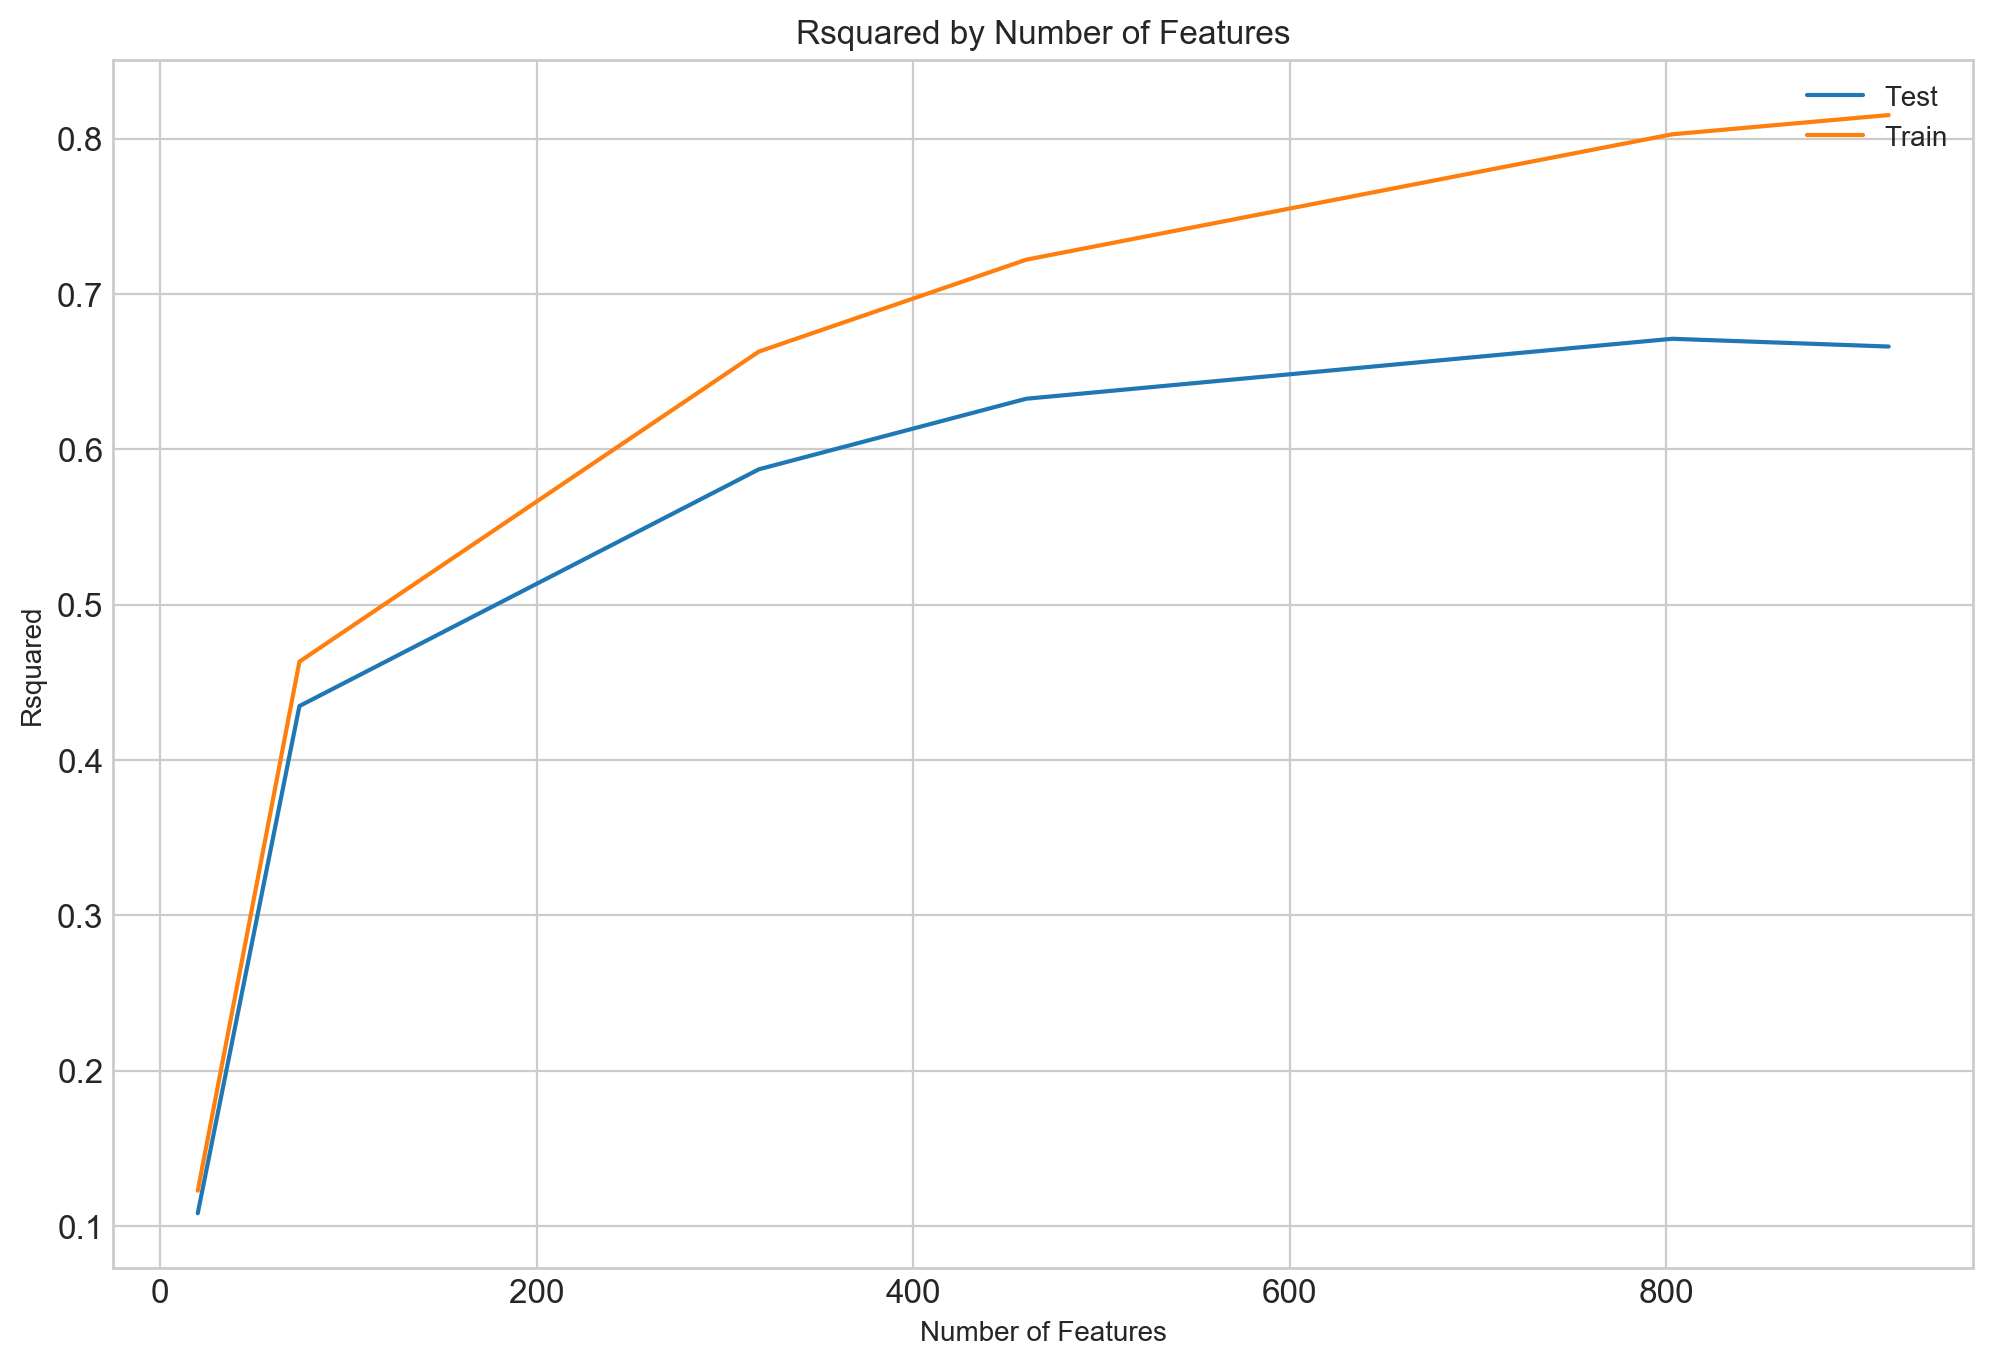

The best cutoff is: 0.01
The optimal number of features is: 803


In [29]:
# Defined cutoffs as ratio of 1s in a certain column
cutoffs = [0.5, 0.3, 0.1, 0.05, 0.01, 0.007]

# Get the function results with variables
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [30]:
# Examine the model coefficients
coef = pd.DataFrame()
coef['feature'] = X_train.columns
coef['coef'] = lm_model.coef_
coef['abs_coef'] = abs(coef['coef'])

# The top five coefficients
coef.sort_values('abs_coef',ascending=False).head()

,feature,coef,abs_coef
26,EmploymentStatus_Employed part-time,-2.529867e+17,2.529867e+17
25,EmploymentStatus_Employed full-time,-2.529867e+17,2.529867e+17
4,"ProgramHobby_Yes, both",7.223060e+15,7.223060e+15
2,"ProgramHobby_Yes, I contribute to open source ...",7.223060e+15,7.223060e+15
3,"ProgramHobby_Yes, I program as a hobby",7.223060e+15,7.223060e+15
